In [42]:
# === ENVIRONMENT SETUP ===
import sys
from pathlib import Path
import shutil

IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    # Remove old repo if exists
    if Path('Projects').exists():
        shutil.rmtree('Projects')

    # Clone fresh copy
    !git clone https://github.com/Q-types/Projects.git
    sys.path.insert(0, '/content/Projects')

# Import my utilities
from data_science.data_utils import ensure_dataset
from data_science.colab_setup import CFG, apply_style

print(f"✅ Setup complete! Data folder: {CFG.data_folder}")


Cloning into 'Projects'...
remote: Enumerating objects: 39, done.
remote: Counting objects: 100% (39/39), done.
remote: Compressing objects: 100% (33/33), done.
remote: Total 39 (delta 7), reused 35 (delta 3), pack-reused 0 (from 0)
Receiving objects: 100% (39/39), 1.16 MiB | 4.25 MiB/s, done.
Resolving deltas: 100% (7/7), done.
✅ Setup complete! Data folder: /content/Projects/data_science/datasets/raw


In [43]:
# === INSTALL PROPHET (Colab only) ===
if IN_COLAB:
    print("📦 Installing Prophet...")
    !pip install -q prophet
    print("✅ Prophet installed!")

📦 Installing Prophet...
✅ Prophet installed!


In [44]:
import itertools
from tokenize import PlainToken
import pandas as pd
import numpy as np
from random import gauss
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller

from pandas.plotting import autocorrelation_plot
from sklearn.feature_selection import RFECV
from sklearn.linear_model import Ridge

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from dateutil.easter import easter
from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics
from prophet.plot import plot_yearly, add_changepoints_to_plot

import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

# Apply my custom plotting style (imported from cell 1)
apply_style('clean')

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import plotly.graph_objs as go

print("✅ Imports complete")



✅ Imports complete


📥 Downloading dataset 'us_covid' from Kaggle...
Using Colab cache for faster access to the 'tsdata-1' dataset.
   Copied: medium_posts.csv
   Copied: daily-minimum-temperatures-in-me.csv
   Copied: example_air_passengers.csv
   Copied: google_chg.csv
   Copied: outdoor-temperature-12UTC.csv
   Copied: exp1.csv
   Copied: exp2.csv
   Copied: quarterly_gdp_change.csv
   Copied: irish_electricity_daily.xlsx
   Copied: Sample - Superstore.xls
   Copied: ex1_wiki_visits.csv
   Copied: arma_series2.csv
   Copied: example_wp_log_R_outliers2.csv
   Copied: diabetic.csv
   Copied: ambient_temperature_system_failure.csv
   Copied: rossman_sales.csv
   Copied: energy_daily.csv
   Copied: example_retail_sales.csv
   Copied: avocado.csv
   Copied: example_wp_log_R_outliers1.csv
   Copied: iroots.png
   Copied: passengers.csv
   Copied: exp3.csv
   Copied: us_energy.csv
   Copied: passengers_test.csv
   Copied: irish_electricity.csv
   Copied: tesla_prices_5y.csv
   Copied: passengers_train.csv
   C

<Axes: >

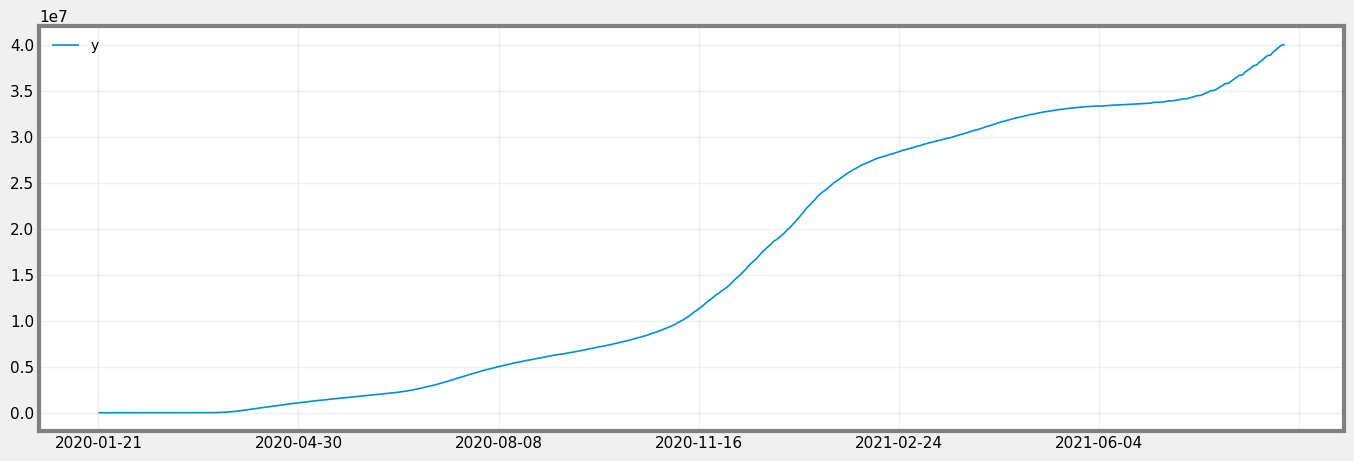

In [45]:
# Ensure dataset is available (downloads if needed)
data_folder = ensure_dataset("us_covid")

# Load data
df = pd.read_csv(data_folder / "us_covid.csv")
xdat = df[["date","cases"]].rename(columns={"date":"ds","cases":"y"})
xdat.set_index("ds").plot(figsize=(CFG.img_dim1, CFG.img_dim2), xlabel="")

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


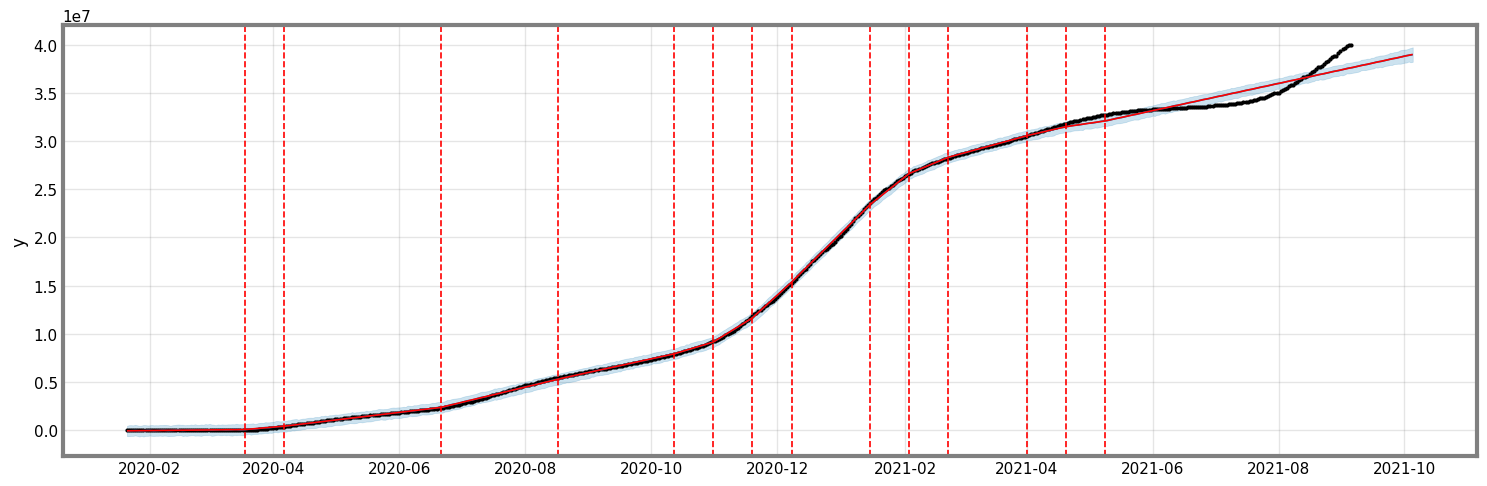

In [51]:
# automatic detection of change points

m = Prophet()
m.fit(xdat)
future = m.make_future_dataframe(periods=30)
forcast = m.predict(future)
fig = m.plot(forcast, figsize=(CFG.img_dim1, CFG.img_dim2), xlabel = '')
a = add_changepoints_to_plot(fig.gca(), m, forcast)

In [50]:
# Re-install Prophet with necessary dependencies
if IN_COLAB:
    print("📦 Re-installing Prophet with dependencies...")
    !pip install -q --upgrade --no-cache-dir prophet cmdstanpy
    print("✅ Prophet re-installed!")

📦 Re-installing Prophet with dependencies...
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 241.8 MB/s eta 0:00:00
✅ Prophet re-installed!


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


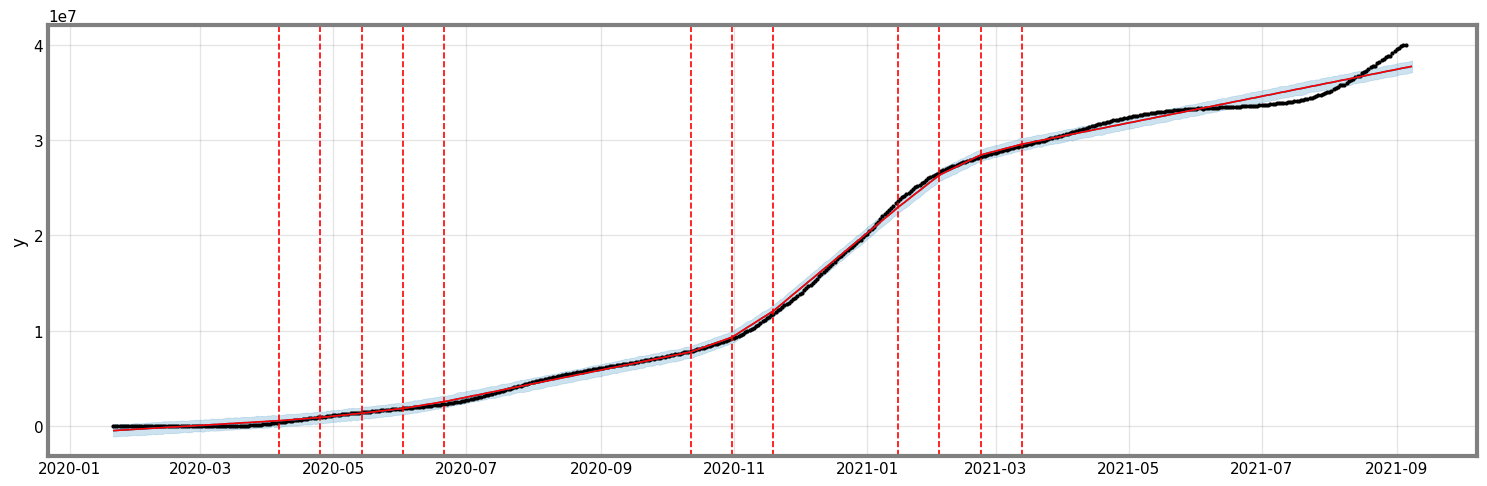

In [54]:
m = Prophet(changepoint_prior_scale=0.01)
m.fit(xdat)
future = m.make_future_dataframe(periods=3)
forcast = m.predict(future)
fig = m.plot(forcast, figsize=(CFG.img_dim1, CFG.img_dim2), xlabel = '')
a = add_changepoints_to_plot(fig.gca(), m, forcast)

In [59]:
# Ensure WHO dataset is available
ensure_dataset("who_cases")

# Load using CFG.data_folder
df = pd.read_csv(CFG.data_folder / "WHO_full_data2003.csv")

✅ Dataset 'who_cases' already available


<Axes: >

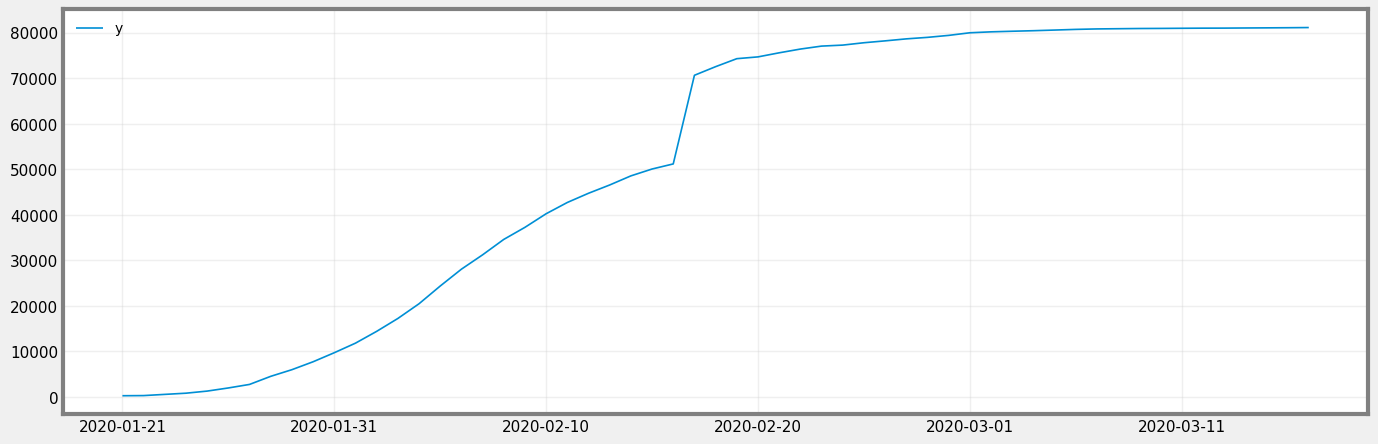

In [60]:
# Subset data and rename to Prophet naming convention

df = df.loc[df['location'] == 'China'][['date', 'total_cases']].rename(columns={'date':'ds', 'total_cases':'y'})
df.set_index('ds').plot(figsize=(CFG.img_dim1,CFG.img_dim2), xlabel='')

The curve of cases begins to flatten. Usign prophet we can incorporate such knowledge into the model by setting an upper bound

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


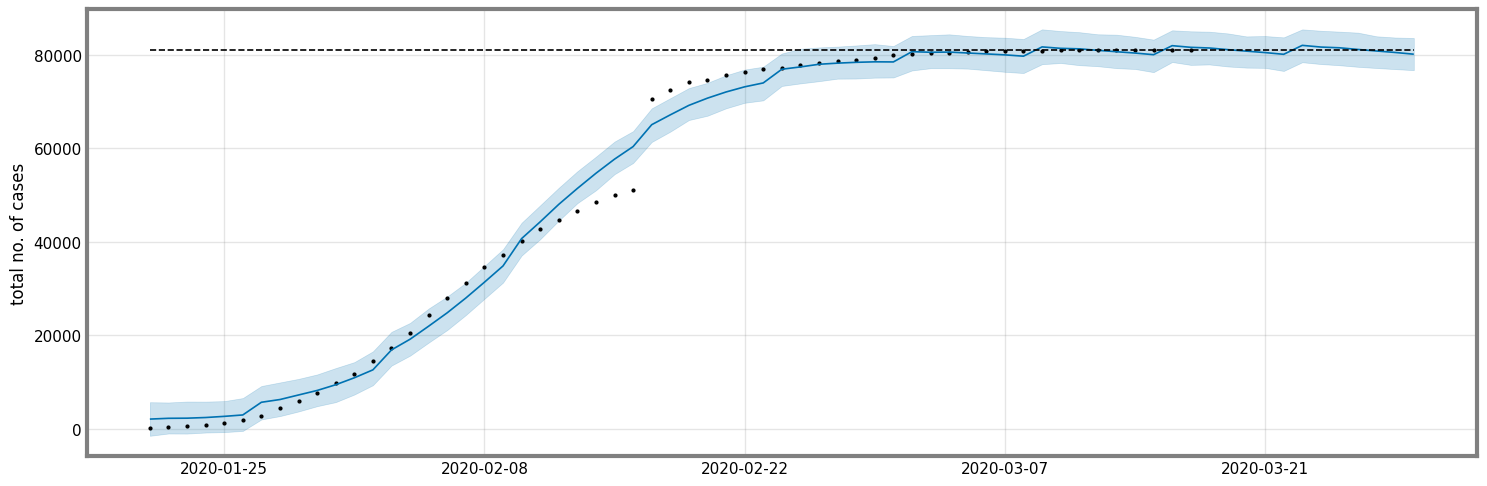

In [62]:
# adding cap

df['cap'] = df['y'].max()

# fit model
m = Prophet(growth='logistic')
m.fit(df)

# prediction
future = m.make_future_dataframe(periods=12)
future['cap'] = df['cap'].iloc[-1]

# plot results
fcst = m.predict(future)
fig = m.plot(fcst, figsize=(CFG.img_dim1, CFG.img_dim2), xlabel = '', ylabel = 'total no. of cases')

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


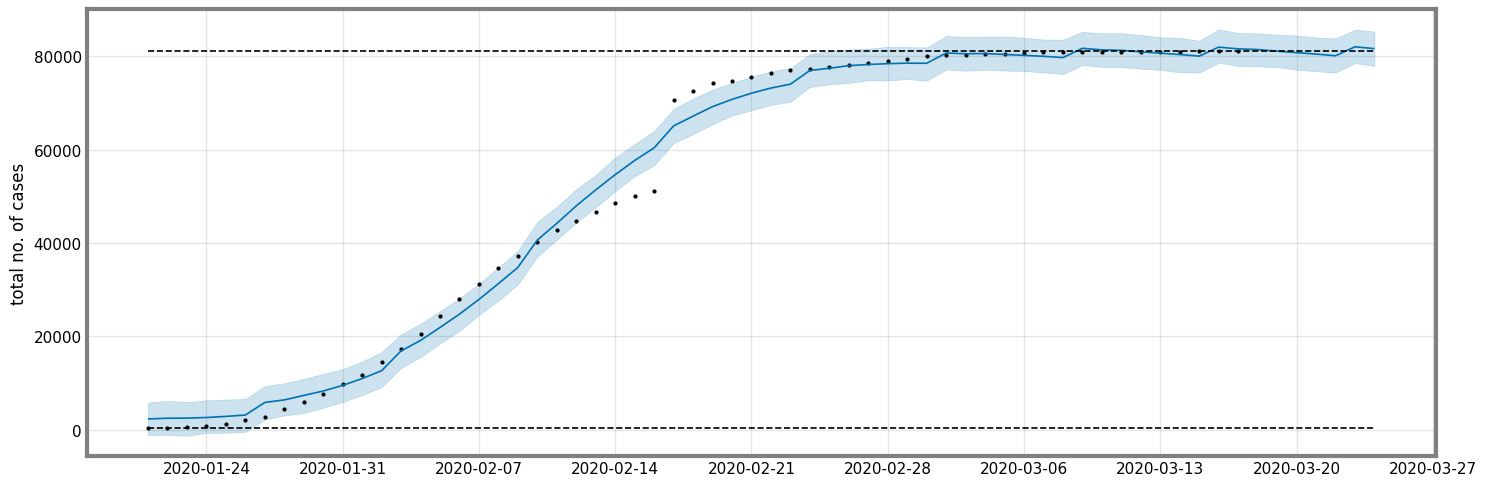

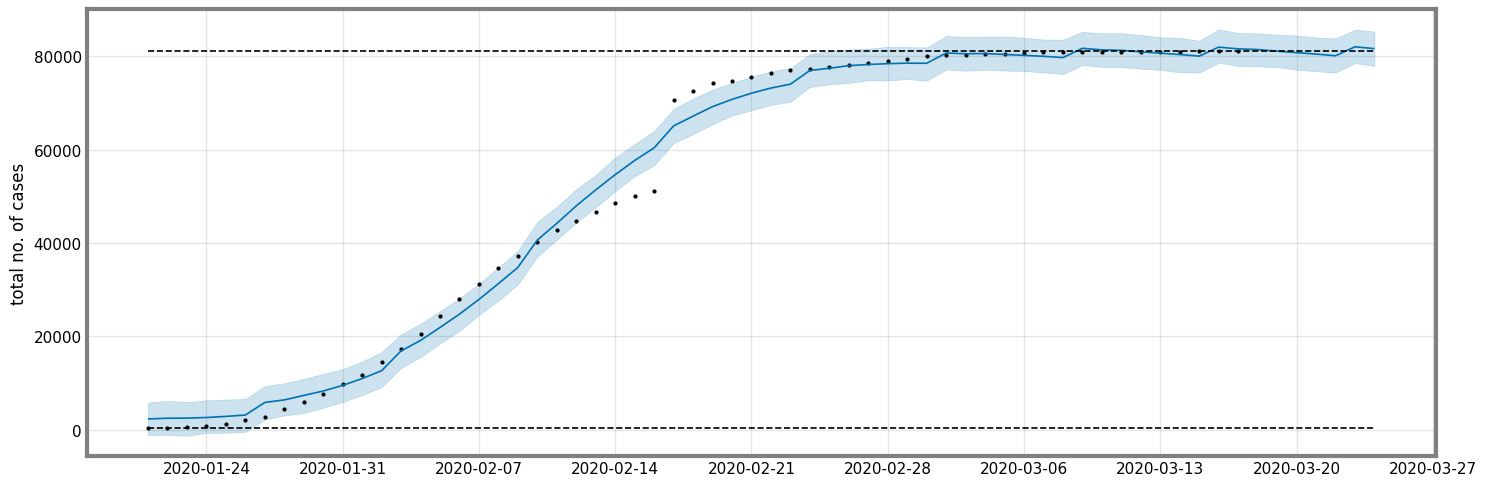

In [64]:
# now settign lower bounds

df['cap'] = df['y'].max()
df['floor'] = df['y'].min()

# fit model
m= Prophet(growth='logistic')
m.fit(df)

# prediction
future = m.make_future_dataframe(periods=7)
future['cap'] = df['cap'].iloc[-1]
future['floor'] = df['floor'].iloc[-1]
fcst = m.predict(future)

m.plot(fcst, figsize=(CFG.img_dim1, CFG.img_dim2), xlabel = '', ylabel = 'total no. of cases')

Seasonality